## Glasovne storitve, načrtovanje uporabniškega poskusa

Cilji: Izvesti uporabniški poskus z govornim vmesnikom (Aleksa storitev) in pridobiti podatke uporabnikov za kasnejše analize.

Navodila:

1. Izberite si tematiko pogovora (cilj, kakšne informacije želite pridobiti s pomočjo Alekse).

2. Preiščite Aleksa storitve in poiščite primerno storitev, ki vam bo posredovala željene informacije preko pogovora.

https://www.amazon.com/alexa-skills/b/?ie=UTF8&node=13727921011&ref_=topnav_storetab_a2s


3. Naložite si Amazon Alexa aplikacijo na telefon. 


4. Izpolnite pred-vprašalnik

https://docs.google.com/forms/d/e/1FAIpQLSdayM33ZHGBKuPdFIcqMZWjrvxpWRCzxdX9dxu8jaXOPSHVLw/viewform?usp=pp_url


5. Preizkusite izbrano storitev: pogovor naj vsebuje vsaj 5 interakcij.


6. Izpolnite vprašalnik o kvaliteti pogovora.

https://docs.google.com/forms/d/e/1FAIpQLSdIL_h_Ebx93BPDGCo4UAgwD3hMQM6wM7kHBiTGeUTT_5AqbQ/viewform?usp=sf_link





#### Izračun metrike uspešnosti

Faktorska matrika da tudi uteži, s katerimi množimo številske vrednosti odgovorov in s tem ocenimo posamezne latentne spremenljivke - dimenzije.

Dobljene uteži so navedene spodaj. To so uteži, s katerimi pomnožimo odgovore in s tem pridobimo ocene dimenzij (latentnih faktorjev) UGO, CSB, SC in V za posamezne respondente.

* The User Goal Orientation items relate to the system’s efficiency, user trust, confidence in the 
system, and clarity of the speech interface. 
* Customer Service Behavior includes items that relate to the friendliness and politeness of the system, its speaking pace, and its use of familiar terms. 
* The Speech Characteristics factor relates to naturalness and enthusiasm of the system 
voice. 
* Verbosity includes items related to the talkativeness and repetitiveness of the system.  



In [35]:
# Load data 
# Odgovori na vprasanja
# primer s predavanj, kasneje bomo spremenili link na naš poskus
#post_fn = 'https://raw.githubusercontent.com/andrejkk/UPK_DataImgs/master/PredPost-vprasalnik(dvogovor)(Responses).csv'
post_fn = '2020.csv'

In [36]:

import numpy as np
import pandas as pd 
from scipy.optimize import minimize


# @brief reshape ND array to 1D as required by binary FA
# @arg nS number of samples
# @arg nQ number of questions
def reshape_NDto1D(a_nparr, nS, nQ):
    return a_nparr.T.reshape(nS*nQ)


# @brief reshape 1D array back to ND as required by binary FA
# @arg nS number of samples
# @arg nQ number of questions
def reshape_1DtoND(a_nparr, nS, nQ):    
    return a_nparr.reshape(nQ, nS).T


# @brief Get linear scores using direct optimisation. 
# @arg qa_mat anwsers matrix, users raws, questions columns
# @arg la_mat loadings  
# @arg cls0_trsh=0.5 ignored
# @ret S_star resulting scores
def get_linear_scores_D(qa_mat, la_mat, cls0_trsh=0.5):
    
    nS, nQ = qa_mat.shape # Number of samples and number of questions
    _, nF = la_mat.shape # Number of factors


    reg_la = 1.0 # Regularisation constant

    # Cost function    
    def cost_f(Sc_1D):
        Sc = reshape_1DtoND(Sc_1D, nS, nF)
        err_mat = qa_mat - Sc @ la_mat.T
        cost_err = np.linalg.norm(err_mat) + reg_la*np.abs(1 - np.linalg.norm(Sc))
        return cost_err


    # Minimsation
    S0 = np.ones((nS, nF)) / (1.0*np.sqrt(nS)) # To start with |S0|_2 = 1
    S0_1D = reshape_NDto1D(S0, nS, nF)
    
    
    res = minimize(cost_f, S0_1D) #, method='nelder-mead',
               #options={'xatol': 1e-8, 'disp': True})
    
    S_star = reshape_1DtoND(res.x, nS, nF) # This are scores    
    
    return S_star

In [37]:
## Estimate quality of speech interface 
# User Goal Orientation = UGO: 8 items, a = .92
# Customer Service Behaviors = CSB: 8 items, a = .89
# Speech Characteristics = SC: 5 items
# Verbosity = V: 4 items, a = .69


import numpy as np
import pandas as pd 

# Load data 

data_df = pd.read_csv(post_fn, header=0, sep=';', encoding='utf8')
#print(data_df)

#qs_weights_fn = 'https://raw.githubusercontent.com/andrejkk/UPK_DataImgs/master/QualityOfConvSys_Weights.cvs'
#qs_weights_df = pd.read_csv(qs_weights_fn, header=0, sep=';', encoding='utf8')


  
    
# nove utezi
qs_weights_df= pd.DataFrame(
[[0.799, 0, 0, 0],
[0, 0, 0, 0.706],
[0.8, 0, 0, 0],
[0, 0.711, 0, 0],
[0.805, 0, 0, 0],
[0, 0.758, 0, 0],
[0.628, 0, 0, 0],
[0, 0, 0, 0.701],
[0, 0.736, 0, 0],
[0.831, 0, 0, 0],
[0, 0.739, 0, 0],
[0.834, 0, 0, 0],
[0.858, 0, 0, 0],
[0, 0.726, 0, 0],
[0, 0, 0, 0.655],
[0, 0, 0.585, 0],
[0.834, 0, 0, 0],
[0, 0, 0.808, 0],
[0.794, 0, 0, 0],
[0, 0, 0.797, 0],
[0, 0.599, 0, 0],
[0, 0, 0, 0.73],
[0, 0.648, 0, 0],
[0, 0, 0.658, 0],
[0, 0.668, 0, 0]])

# Selectors 
post_qs_inds = list(range(11,36))
# print(post_qs_inds)

data_qs_df = data_df.iloc[:, post_qs_inds]
# print(data_qs_df.head())

# Estimate latent variables
# speech_quality_est = data_qs_df.dot(qs_weights_df.as_matrix())


# Estimate latent variables
qa_mat = data_qs_df.to_numpy()
la_mat = qs_weights_df.to_numpy()
speech_quality_est_np = get_linear_scores_D(qa_mat, la_mat) # was data_qs_df.dot(qs_weights_df.to_numpy())

speech_quality_est_df = pd.DataFrame(speech_quality_est_np)
speech_quality_est_df.columns = ['UGO', 'CSB', 'SC', 'V']



speech_quality_est = speech_quality_est_df

#speech_quality_est.columns = ['UGO', 'CSB', 'SC', 'V']

speech_quality_est

,UGO,CSB,SC,V
0,5.467799,5.436673,4.488214,5.713732
1,7.603317,7.123910,6.358333,6.723101
2,4.866914,4.942031,3.813556,5.472079
3,5.573534,4.549578,4.711314,4.388352
4,6.780832,6.354681,6.338700,5.715589
5,5.785153,6.481133,4.355066,5.678789
6,6.438740,6.521491,4.822332,5.189899
7,6.913612,5.674120,5.088619,5.714849
8,6.770532,6.327844,5.345635,5.151236
9,5.518062,5.116791,3.805704,4.619227


#### Korak 1: Določitev ciljev eksperimenta

Cilj eksperimentalne študije

Cilj je odgovor na Raziskovlano vprašanje. To je vprašanje, na katerega z izvedbo eksperimenta odgovarjamo.

V našem primeru je raziskovalno vpršanje "Ali naprava (simulator ali Echo) vpliva na zaznano kvaliteto pogovora?"

#### Statistični načrt poskusa

Poznamo več različnih načrtov, med drugim (glejte poglavje 12.3)

    ANOVA
    Latinski kvadrat
    ulomljeni (angl. fractional)

#### Korak 8: Analiza rezultatov

Eksperimentalni načt: testiranje hipotez

Eksperimentalni načrt da podatke za testiranje hipotez

* iz raziskovalnega vprašanja oblikujemo delovno hipotezo
        
naš primer pogovora z Alexo:
* raziskovalno vprašanje: ali vmesnik (Echo ali simulator) vpliva da percepcijo kvalitete dvogovora?
            
* delovna hipoteza: vmesnik vpliva na percepcijo kvalitete dvogovora

* na podlagi delovne hipoteze oblikujemo ničelno hipotezo

naš primer pogovora z Alexo:  ničelna hipoteza pomeni, da ni razlike (ne vpliva).
            H0=[y¯¯¯S=y¯¯¯E],
            
          povprečje za Echo je enako povpr. za PC
            

kjer je y¯¯¯S povprečje rezultatov skupine s simulatorjem in y¯¯¯E povprečje rezultatov skupine z napravo Echo.

Ničelna hipoteza velja (ni razlike), če je stopnja tveganja p več kot 0,05, razlike so bile rezultat naključja. V tem primeru delovna hipoteza (da obstaja razlika med PC in Echo) ni potrjena.

Primer: enosmerna ANOVA s fiksnim učinkom
    


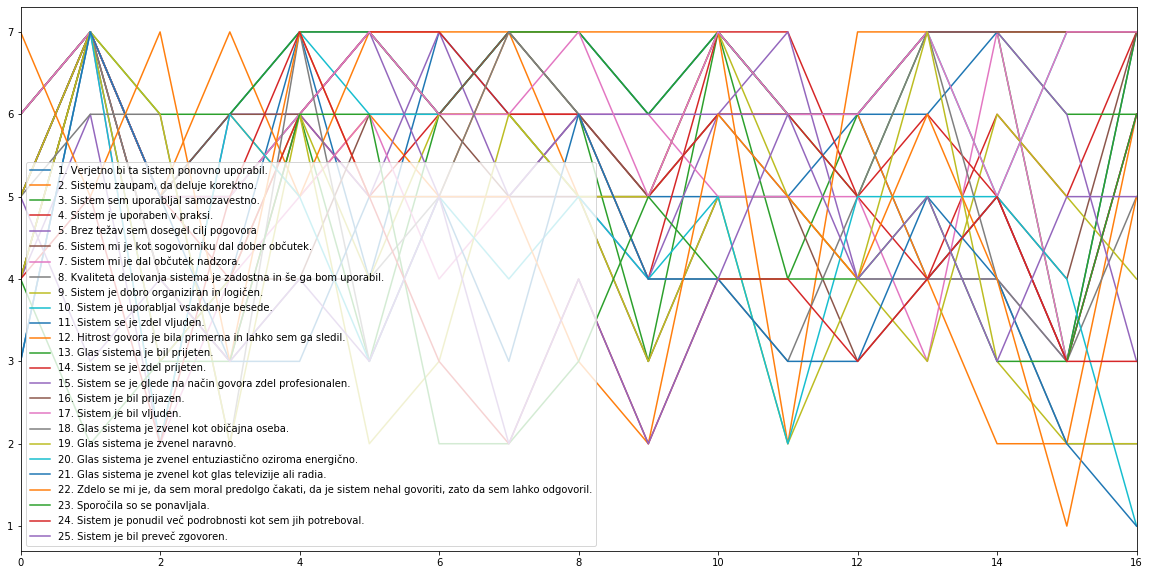

In [23]:
## Analysis of results 
import numpy as np
import pandas as pd 
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Load data 
data_df = pd.read_csv(post_fn, header=0, sep=';', encoding='utf8')

# Selectors 
post_qs_inds = list(range(11,36))
anws_df = data_df.iloc[:, post_qs_inds]

# Plot answers
anws_df.plot(figsize=(20,10))

In [24]:

# Define functions
def get_ANOVA_SS(data_df):
    a,n = data_df.shape
    N = a*n
    
    y_pp = 1.0*data_df.sum().sum()
    y_ip = 1.0*data_df.sum(axis=1)
    
    # SS total
    SS_T = (data_df**2).sum().sum() - (y_pp**2)/N

    # SS treatment
    SS_trt = (1.0/n)*(y_ip**2).sum() - (y_pp**2)/N
    
    # SS error
    SS_err = SS_T - SS_trt
   
    # Report
    return SS_trt, SS_err, SS_T

In [25]:
# one-way ANOVA fixed factor
speech_quality_est

## ANOVA
import pandas as pd 
from scipy.stats import f

# RAZPOREDITEV V SKUPINE
latent_fs = ['UGO', 'CSB', 'SC', 'V']
groups = {}
groups['PC'] = [0, 1, 2, 3, 4, 5, 6, 7]
groups['Echo'] = [8, 9, 10, 11, 12, 13, 14, 15]

#groups['PC'] = [8, 1, 10, 3, 12, 5, 6, 7]
#groups['Echo'] = [0, 9, 2, 11, 4, 13, 14, 15]

# Test : če damo enake userje
# groups['Echo'] = [8, 9, 10, 15]



# For all vars
for fs_n in latent_fs:
    
    # Select groups
    sq_est_PC = speech_quality_est[fs_n][groups['PC']]
    sq_est_Echo = speech_quality_est[fs_n][groups['Echo']]
    
    print("Podatki skupina 1 PC : ")
    print(sq_est_PC)
    print("Podatki skupina 2 Echo : ")
    print(sq_est_Echo)
    
    # Compute SS
    curr_df = pd.DataFrame([sq_est_PC.as_matrix(), sq_est_Echo.as_matrix()]) #, columns = [1,2,3,4,5,6,7,8])
    SS_trt, SS_err, SS_T = get_ANOVA_SS(curr_df)
    
 
    # F-stat
    a,n = data_df.shape
    N = a*n
    F_0 = (SS_trt/(a-1)) / (SS_err/(N-a))
    
    # P-value
    p_val = 1-f.cdf(F_0, a-1, N-a)
    
    # Report
    print("Rezultat : ")
    print ('      Latent var:', fs_n, 'p-val=', p_val)
    print("")

Podatki skupina 1 PC : 
0    5.481408
1    7.622220
2    4.879034
3    5.587399
4    6.797692
5    5.799539
6    6.454755
7    6.930800
Name: UGO, dtype: float64
Podatki skupina 2 Echo : 
8     6.787371
9     5.531785
10    6.937887
11    5.294071
12    6.046498
13    6.617905
14    6.125684
15    5.134002
Name: UGO, dtype: float64
Rezultat : 
      Latent var: UGO p-val= 0.996763651199937

Podatki skupina 1 PC : 
0    5.455581
1    7.148632
2    4.959238
3    4.565433
4    6.376754
5    6.503640
6    6.544139
7    5.693849
Name: CSB, dtype: float64
Podatki skupina 2 Echo : 
8     6.349824
9     5.134595
10    6.701618
11    6.384076
12    5.148382
13    5.697940
14    5.949989
15    5.191898
Name: CSB, dtype: float64
Rezultat : 
      Latent var: CSB p-val= 0.9999814182339197

Podatki skupina 1 PC : 
0    4.514218
1    6.395147
2    3.835664
3    4.738610
4    6.375396
5    4.380305
6    4.850265
7    5.118098
Name: SC, dtype: float64
Podatki skupina 2 Echo : 
8     5.376596
9     3.8

C:\P_Dev\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


### Naloga 1

1. Katera izmed vprašanj (vprašalnika) vplivajo na izračun posamezne dimenzije (faktorja) ocene sistema?
2. Izberi si vprašanje, ki ga boš zastavil sistemu (kakšno informacijo želiš).
3. Izvedi pogovor z zvočnim sistemom, in izpolni post-vprašalnik (oceni delovanje sistema)
4. Komentiraj delovanje sistema.

### Naloga 2: analiza 

1. Naloži podatke (CSV) in definiraj 2 skupini uporabnikov (glede na sistem, ki so ga uporabili)

Podatke bomo dobili na: 
https://github.com/jzaletelj/OTK_LV08_Data

2. Ugotovi in komentiraj, ali so se faktorji dveh skupin uporabnikov statistično razlikovali med seboj (p-vrednost), in kateri sistem je dal boljši rezultat pri pogovoru.